In [1]:
import numpy as np
import h5py
import json
import os
import pandas as pd
from model import *
from IPython import display
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from matplotlib.cm import ScalarMappable
matplotlib.rcParams['animation.embed_limit'] = 40
matplotlib.rcParams['animation.ffmpeg_path'] = '/Users/patrick/Downloads/ffmpeg'

In [3]:
# Get list of run numbers
rundirs = os.listdir('runs')
try:
    runnums = np.arange(len(rundirs.remove('.DS_Store')))
except:
    runnums = np.arange(len(rundirs))

scatter plots

    x-axis
        K
        - proportional rate of change (like climate change exposure rate) for the longest period between merging/splitting events
        fire prob
        - average over space and time for the longest period between merging/splitting events
        - (proportional?) rate of change for the longest period between merging/splitting events
    y axis
        - proportional abundance rate of change for the longest period between merging/splitting events
        
how much does the change in fire prob matter?
    
    histogram changes in prob over patches, compare to popsuc vs fireprob single patch test

using existing run: True, run_num=74, run_dir=C:\Users\12488\Research\Regan\Tecate cypress\runs\74


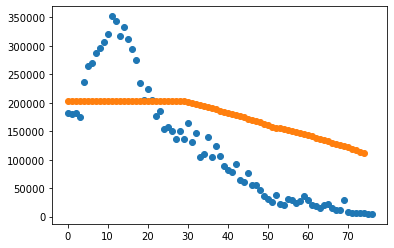

In [23]:
run = open_run(74)
pop = 'pop20'
with h5py.File(os.path.join(run.run_dir, 'results.h5'), 'r') as res:
    ab = np.array(res['mean'][pop])
    Ks = np.array(res['K'][pop])
plt.scatter(range(len(ab)), ab)#; [(a, t) for a, t in zip(ab, range(len(ab)))]
# plt.show()
plt.scatter(range(len(Ks)), Ks)#; [(K, t) for K, t in zip(Ks, range(len(Ks)))]
plt.show()

run 0
using existing run: True, run_num=0, run_dir=C:\Users\12488\Research\Regan\Tecate cypress\runs\0
<KeysViewHDF5 ['K', 'fire_prob', 'max', 'mean', 'min', 'patch_centroids', 'stdev']>


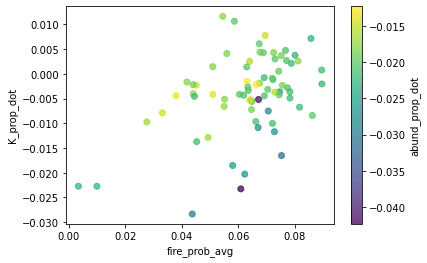

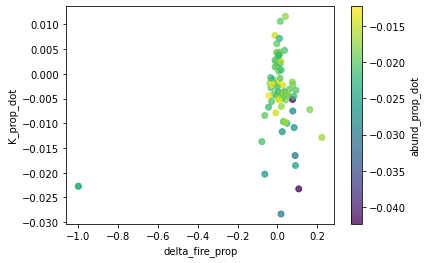

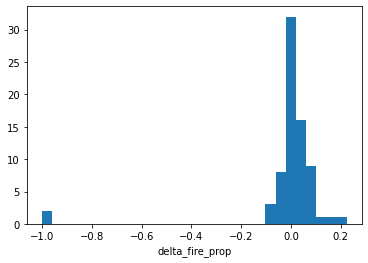

(array([ 2.,  0.,  0.,  0.,  1.,  2.,  4.,  3.,  2.,  5., 13., 12.,  8.,
        2.,  7.,  7.,  1.,  2.,  0.,  2.]), array([-1.        , -0.92438776, -0.84877552, -0.77316327, -0.69755103,
       -0.62193879, -0.54632655, -0.47071431, -0.39510206, -0.31948982,
       -0.24387758, -0.16826534, -0.0926531 , -0.01704085,  0.05857139,
        0.13418363,  0.20979587,  0.28540811,  0.36102036,  0.4366326 ,
        0.51224484]), <BarContainer object of 20 artists>)


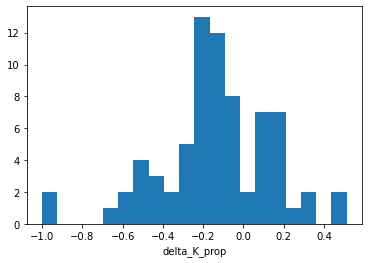

In [24]:
data_keys = ['K_prop_dot', 'fire_prob_avg', 'delta_fire_prob', 'delta_fire_prop', 'abund_prop_dot', 'delta_t']
# for runnum in runnums:
# for runnum in [0,74]:
for runnum in [0]:
    print('run',runnum)
    run = open_run(runnum)
    # Select specific climate model/scenario
    if (run.spatial == False) or (run.climate_model != 'cnrm') or (run.climate_scenario != 'rcp45'):
        continue

    # Initialize data
    if run.fixed_habitat == False:
        with open(os.path.join(run.run_dir, 'final.mp'), 'r') as mp:
            mpdata = mp.readlines()
        pops = np.arange(run.get_num_pops())
        
        # data = {key: {str(pop): [] for pop in pops} for key in ['K_prop_dot', 'fire_prob_avg', 'abund_prop_dot']}
        data = {key: {} for key in data_keys}
        
        # Process the splits and merges
        '''Could also process the splits under this loop'''
        expected_len = 22 #of the pop management log lines
        splits = {str(pop): [] for pop in pops}
        merges = {str(pop): [] for pop in pops}
        
        # Find line where pop management log starts
        for ln_idx, ln in enumerate(mpdata):
            if 'pop mgmnt' in ln:
                pop_mgmnt_idx = ln_idx; break
        for ln_idx, ln in enumerate(mpdata):
            if ln_idx > pop_mgmnt_idx:
                ln_splt = ln.split()
                if 'Simulation results' in ln:
                    break
                elif len(ln_splt) != expected_len:
                    # Skip if not a pop management log line
                    continue
                
                if float(ln_splt[10]) == 1.0:
                    # Process splits
                    merges[ln_splt[3]].append(int(ln_splt[4]))
                else:
                    # Process merges
                    splits[ln_splt[2]].append(int(ln_splt[4]))
    
    # Access the run's results
    with h5py.File(os.path.join(run.run_dir, 'results.h5'), 'r') as res:
        print(res.keys())
        for pop in pops[1:]:
            poplab = 'pop'+str(pop)
            
            # Filter out populations with zero abundance for whole simulation
            if np.all(np.array(res['mean'][poplab]) == 0):
                continue
            # print(pop)
            
            # Find timestep where this population appears
            init_i = np.nonzero(res['mean'][poplab])[0][0]
            # For pops in frame 0, account for the burn in period
            if init_i == 0:
                init_i = init_i + run.burn_in_period
            
            # Check for local extinction / merging into another pop
            abund = np.array(res['mean'][poplab])
            final_i = int(np.round((proj_info['tf']-proj_info['ti'])/run.timestep)) + run.burn_in_period
            ext = False
            for t in range(final_i):
                if (abund[t] > 0) and (abund[t+1] == 0):
                    final_i = t if t > run.burn_in_period else run.burn_in_period
                    break
            
            # Set the interval over which to calculate population metrics
            t_interval = [init_i, final_i]
            if not run.fixed_habitat:
                # Find the longest interval without merging/splitting
                if (len(splits[str(pop)]) > 0) or (len(merges[str(pop)]) > 0):
                    times = sorted([init_i] + splits[str(pop)] + merges[str(pop)] + [final_i])
                    intervals = np.array([times[i] - times[i-1] for i in range(len(times))[1:]])
                    max_int_i = np.where(intervals == max(intervals))[0][0]
                    t_interval[0] = times[max_int_i]
                    t_interval[1] = times[max_int_i + 1]
                    # print(times, '\n', t_interval, '\n')
                else:
                    # print(t_interval, '\n')
                    t_interval[1] = final_i
            '''I cant understand RAMAS' indexing, so this is just a fudge for now'''
            if t_interval[1] > 74:
                t_interval[1] = 74
            delta_t = t_interval[1] - t_interval[0]
            data['delta_t'].update({str(pop): delta_t})
            
            # Require a minimum timespan without merges/splits before tossing out
            if (delta_t) < 10:
                continue
            
            Ks = np.array(res['K'][poplab])
            K_prop_dot = ((Ks[t_interval[1]] - Ks[t_interval[0]]) / Ks[t_interval[0]]) / delta_t
            # print(Ks[t_interval[0]], Ks[t_interval[1]], Kdot)
            data['K_prop_dot'].update({str(pop): K_prop_dot})
            
            fire_probs = np.array(res['fire_prob'][poplab])
            # print(len(fire_probs)); sys.exit()
            fire_prob_avg = np.mean(fire_probs[t_interval[0]:t_interval[1]+1])
            data['fire_prob_avg'].update({str(pop): fire_prob_avg})
            delta_fire_prob = fire_probs[t_interval[1]] - fire_probs[t_interval[0]]
            data['delta_fire_prob'].update({str(pop): delta_fire_prob})
            if delta_fire_prob == 0:
                delta_fire_prop = 0
            else:
                delta_fire_prop = delta_fire_prob / fire_probs[t_interval[0]]
            data['delta_fire_prop'].update({str(pop): delta_fire_prop})
            
            abund_prop_dot = ((abund[t_interval[1]] - abund[t_interval[0]]) / abund[t_interval[0]]) / delta_t
            data['abund_prop_dot'].update({str(pop): abund_prop_dot})
        
    # Plot results
    # axlabs = [['K_prop_dot', 'abund_prop_dot'],
    #           ['fire_prob_avg', 'abund_prop_dot'],
    #           ['delta_fire_prob', 'abund_prop_dot'],
    #           ['delta_fire_prop', 'abund_prop_dot']]
    # for labs in axlabs: 
    #     xlab, ylab = labs[0], labs[1]
    #     x = [data[xlab][pop] for pop in list(data[xlab].keys())]
    #     y = [data[ylab][pop] for pop in list(data[ylab].keys())]
    #     plt.scatter(x, y)
    #     plt.xlabel(xlab); plt.ylabel(ylab)
    #     plt.show()
    
    x = [data['fire_prob_avg'][pop] for pop in list(data['fire_prob_avg'].keys())]
    y = [data['K_prop_dot'][pop] for pop in list(data['K_prop_dot'].keys())]
    c = [data['abund_prop_dot'][pop] for pop in list(data['abund_prop_dot'].keys())]
    vmin = min(c) #-0.035
    plt.scatter(x, y, c=c, vmin=vmin, alpha=0.75)
    plt.colorbar(label='abund_prop_dot')
    plt.xlabel('fire_prob_avg'); plt.ylabel('K_prop_dot')
    plt.savefig(os.path.join(os.getcwd(), 'figs', 'Kvsfire_abundratecolor.png'), bbox_inches='tight')
    plt.show()
    
    x = np.array([data['delta_fire_prop'][pop] for pop in list(data['delta_fire_prop'].keys())])
    y = [data['K_prop_dot'][pop] for pop in list(data['K_prop_dot'].keys())]
    c = [data['abund_prop_dot'][pop] for pop in list(data['abund_prop_dot'].keys())]
    vmin = min(c) #-0.035
    plt.scatter(x, y, c=c, vmin=vmin, alpha=0.75)
    plt.colorbar(label='abund_prop_dot')
    plt.xlabel('delta_fire_prop'); plt.ylabel('K_prop_dot')
    # plt.xlim(-0.05,0.1)
    # plt.savefig(os.path.join(os.getcwd(), 'figs', 'Kpropvsfireprop_abundratecolor.png'), bbox_inches='tight')
    plt.show()

    deltas = np.array([data['delta_fire_prop'][pop] for pop in list(data['delta_fire_prop'].keys())])
    deltas = deltas[np.nonzero(deltas)[0]]
    plt.hist(deltas, bins=30)
    plt.xlabel('delta_fire_prop')
    plt.show()
    
    delta_K_prop = np.array([data['K_prop_dot'][pop] * data['delta_t'][pop] for pop in list(data['delta_fire_prob'].keys())])
    # delta_K_prop = delta_K_prop[np.nonzero(delta_K_prop)[0]]
    hist = plt.hist(delta_K_prop, bins=20)
    print(hist)
    plt.xlabel('delta_K_prop')
    plt.show()
    # break

### Metapopulation abundance

using existing run: True, run_num=0, run_dir=C:\Users\12488\Research\Regan\Tecate cypress\runs\0
using existing run: True, run_num=1, run_dir=C:\Users\12488\Research\Regan\Tecate cypress\runs\1
using existing run: True, run_num=2, run_dir=C:\Users\12488\Research\Regan\Tecate cypress\runs\2
using existing run: True, run_num=3, run_dir=C:\Users\12488\Research\Regan\Tecate cypress\runs\3
using existing run: True, run_num=4, run_dir=C:\Users\12488\Research\Regan\Tecate cypress\runs\4
using existing run: True, run_num=5, run_dir=C:\Users\12488\Research\Regan\Tecate cypress\runs\5
using existing run: True, run_num=6, run_dir=C:\Users\12488\Research\Regan\Tecate cypress\runs\6
using existing run: True, run_num=7, run_dir=C:\Users\12488\Research\Regan\Tecate cypress\runs\7
using existing run: True, run_num=8, run_dir=C:\Users\12488\Research\Regan\Tecate cypress\runs\8
using existing run: True, run_num=9, run_dir=C:\Users\12488\Research\Regan\Tecate cypress\runs\9
using existing run: True, run_

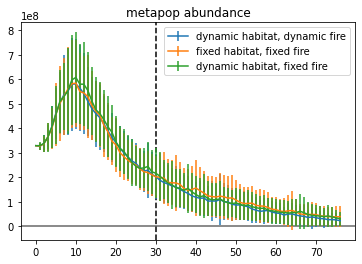

In [25]:
for runnum in runnums:
    run = open_run(runnum)
    # Select specific climate model/scenario
    if (run.spatial == False) or (run.climate_model != 'cnrm') or (run.climate_scenario != 'rcp45'):
        continue
    hab_key = 'fixed' if run.fixed_habitat else 'dynamic'
    fire_key = 'fixed' if run.fixed_fire else 'dynamic'
    run_lab = "{} habitat, {} fire".format(hab_key, fire_key)
    # Access the run's results
    with h5py.File(os.path.join(run.run_dir, 'results.h5'), 'r') as res:
        metapop_abund = np.array(res['mean']['pop0'])
        metapop_stdev = np.array(res['stdev']['pop0'])
    plt.errorbar(range(len(metapop_abund)), metapop_abund, yerr=metapop_stdev, label=run_lab)
plt.title('metapop abundance')
plt.axvline(run.burn_in_period, ls='--', color='k', zorder=-1)
plt.axhline(0, ls='-', color='k', alpha=0.6, zorder=-1)
# plt.ylim(0,2e8)
# plt.xlim(30,75)
plt.legend()

### Single population abundance

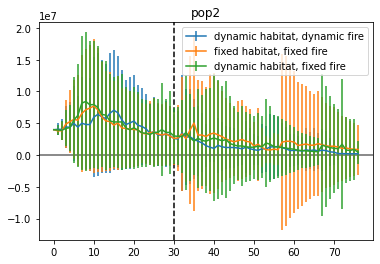

In [33]:
poplab = 'pop2'
for runnum in runnums:
    run = open_run(runnum)
    # Select specific climate model/scenario
    if (run.spatial == False) or (run.climate_model != 'cnrm') or (run.climate_scenario != 'rcp45'):
        continue
    hab_key = 'fixed' if run.fixed_habitat else 'dynamic'
    fire_key = 'fixed' if run.fixed_fire else 'dynamic'
    run_lab = "{} habitat, {} fire".format(hab_key, fire_key)
    # Access the run's results
    with h5py.File(os.path.join(run.run_dir, 'results.h5'), 'r') as res:
        metapop_abund = np.array(res['mean'][poplab])
        metapop_stdev = np.array(res['stdev'][poplab])
    plt.errorbar(range(len(metapop_abund)), metapop_abund, yerr=metapop_stdev, label=run_lab)
plt.title(poplab)
plt.axvline(run.burn_in_period, ls='--', color='k', zorder=-1)
plt.axhline(0, ls='-', color='k', alpha=0.6, zorder=-1)
# plt.ylim(0,1e7)
plt.legend()

### animation

It would make sense if the first time step (t=1) was run with the initial abundances. However, RAMAS seems to run an initial timestep 0 with the initial abundances, as the abundances change (decrease) going from t=0 to t=1. What probability and carrying capacity is used for t=0? Know that (KCH[0], PCH[0]) -> t=1 to t=31,  (KCH[1], PCH[1]) -> t=31 to t=32, (KCH[2], PCH[2]) -> t=32 to t=33, ..., (KCH[45], PCH[45]) -> t=75 to t=76. So for now, I'm going to ignore the first and the last timesteps.

In [ ]:
# Load results into memory as a dictionary
def get_resdata(inst):
    resdata = {}
    resultsfn = os.path.join(inst.run_dir, 'results.h5')
    with h5py.File(resultsfn, 'r') as results:
        for qty in results.keys():
            resdata.update({qty: {}})
            for patch in results[qty].keys():
                if qty in ['mean', 'max', 'min', 'stdev']:
                    # Trim the first and last time step off abundance stats
                    resdata[qty].update({patch: np.array(results[qty][patch])[1:-1]})
                else:
                    resdata[qty].update({patch: np.array(results[qty][patch])})
    return resdata

# Function to return quantity for plotting given keyword
def plot_qty(resdata, patch, t, qty):
    if qty == 'diff_from_init':
        init_i = np.nonzero(resdata['mean'][patch])[0][0]
        val = resdata['mean'][patch][t] - resdata['mean'][patch][init_i]
    if qty == 'scaled_avg_abund':
        val = resdata['mean'][patch][t] / resdata['K'][patch][t]
    if qty == 'rel_to_init':
        init_i = np.nonzero(resdata['mean'][patch])[0][0]
        val = resdata['mean'][patch][t] / resdata['mean'][patch][init_i]
    return val

def update(t):
    # Grab data for time t
    ys, xs, zs, fire_probs = [], [], [], []
    for patch in patches:
        # Check a few things before plotting point
        patch_checks = []
        patch_checks.append(resdata['mean'][patch][t] != 0)
        patch_checks.append(np.all(resdata['mean'][patch] == 0) == False)
        patch_checks.append(((0.0 == 0.0) and (1.0 == 0.0)) == False)
        if (resdata['mean'][patch][t] != 0) and (np.all(resdata['mean'][patch] == 0) == False):
            # Take diff from ylim to convert from row index to y coordinate
            '''Should change indexing in results to (x,y) instead of (y,x)'''
            y = ylim - resdata['patch_centroids'][patch][t][0]
            x = resdata['patch_centroids'][patch][t][1]
            # Check that patch centroid is not a placeholder before storing
            if ((x == 0.0) and (y == ylim)) == False:
                ys.append(y)
                xs.append(x)
            else:
                continue
            # Get value of population success metric
            z = plot_qty(resdata, patch, t, qty)
            zs.append(z)
            # Get pop fire probability at time t 
            prob = resdata['fire_prob'][patch][t]
            fire_probs.append(prob)
    # Plot at a few viewing angles
    fig.clear()
    ms = '^' if t <= 29 else 'o' #change marker for burn in period
    for i, view in enumerate(views):
        ax = fig.add_subplot(2,2,i+1,projection='3d')
        ax.view_init(elev=view[0], azim=view[1])
        ax.ticklabel_format(useOffset=False)
        ax.set_zlim(zmin,zmax)
        ax.set_xlim(0, xlim)
        ax.set_ylim(0, ylim)
        ax.set_xlabel('x coordinate', fontsize=axfont)
        ax.set_ylabel('y coordinate', fontsize=axfont)
        ax.set_zlabel(qty, fontsize=axfont)
        ax.scatter(xs, ys, zs, c=fire_probs, cmap=cmap, norm=norm, 
                   depthshade=False, marker=ms, s=45)
    sm =  ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.75)
    plt.suptitle('{}_{}'.format(inst.climate_model,inst.climate_scenario), fontsize=20)

In [ ]:
for run in runs:
    # Grab a specific run
    with open(os.path.join(os.getcwd(), 'runs', str(run), 'run_info.json')) as info_file:
        run_info = json.load(info_file)
    inst = Model(**run_info)
    
    # Check that this is a spatial run
    if inst.spatial == False:
        continue

    # Load results into memory as a dictionary
    resdata = {}
    resultsfn = os.path.join(inst.run_dir, 'results.h5')
    with h5py.File(resultsfn, 'r') as results:
        for qty in results.keys():
            resdata.update({qty: {}})
            for patch in results[qty].keys():
                if qty in ['mean', 'max', 'min', 'stdev']:
                    # Trim the first and last time step off abundance stats
                    resdata[qty].update({patch: np.array(results[qty][patch])[1:-1]})
                else:
                    resdata[qty].update({patch: np.array(results[qty][patch])})
    patches = list(resdata['patch_centroids'].keys())
    patches.remove('pop0')
    vmax = max([np.max(resdata['fire_prob'][patch]) for patch in patches])
    vmin = min([np.min(resdata['fire_prob'][patch]) for patch in patches if np.min(resdata['fire_prob'][patch]) != 0.0])
    # cmap = matplotlib.colormaps.get_cmap('viridis')#('YlOrRd')
    cmap = matplotlib.pyplot.get_cmap('viridis')
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    xlim = run_info['lr_coord'][0] - run_info['ul_coord'][0]
    ylim = run_info['lr_coord'][1] - run_info['ul_coord'][1]
    axfont = 12
    tsteps = int((proj_info['tf'] - proj_info['ti'])/inst.timestep) + inst.burn_in_period
    ts = np.arange(tsteps)
    qty = 'rel_to_init'
    views = [(10,210),(10,275),(10,340),(85,270)]#,(10,40)]

    all_zs = []
    for t in ts:
        for patch in patches:
            if (resdata['mean'][patch][t] != 0) and (np.all(resdata['mean'][patch] == 0) == False):
                # Get value of population success metric
                z = plot_qty(resdata, patch, t, qty)
                all_zs.append(z)
    zmax, zmin = max(all_zs), min(all_zs)

    fig, ax = plt.subplots(figsize=(8,8), layout='constrained')
    ani = animation.FuncAnimation(fig = fig, func = update, frames = tsteps, interval=100)
    display.HTML(ani.to_jshtml())
    # path = '/Users/patrick/Google Drive/My Drive/Research/Regan/Figs'
    # path = 'G:\My Drive\Research\Regan\Figs'
    path = os.path.join(os.getcwd(), 'figs')
    fn = '{}_{}_{}.mp4'.format(inst.climate_model,inst.climate_scenario,qty)
    writervideo = animation.FFMpegWriter(fps=15)
    # ani.save(os.path.join(path, fn), writer=writervideo)
    ani.save('test.mp4', writer=writervideo)

## regional K

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
for patch in patches:
    if np.all(resdata['mean'][patch] > 0):
        ys = ylim - resdata['patch_centroids'][patch][:,0]
        xs = resdata['patch_centroids'][patch][:,1]
        if np.all(xs > xlim/2) and np.all(ys < ylim/2):
            ax.plot(resdata['K'][patch], color='orange')
        else:
            ax.plot(resdata['K'][patch], color='green')
ax.plot([], [], color='orange', label='south-east')
ax.plot([], [], color='green', label='north-west')
ax.legend()

## ( K(x,t) / (initial_#_cells(x)) ) / K_cell

## single patch

In [ ]:
fire_probs = []
ab_ratios = []
for run in runs:
    with open(os.path.join(os.getcwd(), 'runs', str(run), 'run_info.json')) as info_file:
        run_info = json.load(info_file)
    inst = Model(**run_info)
    
    # Check that this is a single patch (non-spatial) run
    if inst.spatial == True:
        continue
    
    resdata = get_resdata(inst)
                    
    fire_probs.append(inst.fire_prob)
    tsteps = int((proj_info['tf'] - proj_info['ti'])/inst.timestep) + inst.burn_in_period
    ts = np.arange(tsteps)
    ab_ratios.append(plot_qty(resdata, 'pop0', ts[-1], 'rel_to_init'))
    # break

In [ ]:
plt.scatter(fire_probs, ab_ratios)
plt.ylabel('final / initial abundance', fontsize=14)
plt.xlabel('fire probability', fontsize=14)
plt.axvline(0.02, ls='--')
plt.axvline(0.09, ls='--')
plt.savefig('figs/popsuc_vs_fireprob.png')

In [ ]:
plt.scatter(inst.timestep / np.array(fire_probs), ab_ratios)
plt.ylabel('final / initial abundance', fontsize=14)
plt.xlabel('expected FRI', fontsize=14)
plt.axvline(20, ls='--')
plt.axvline(100, ls='--')
plt.savefig('figs/popsuc_vs_fri.png')

In [ ]:
plt.scatter(np.array(fire_probs), inst.timestep / np.array(fire_probs))
plt.axvline(0.02, ls='--')
plt.axvline(0.09, ls='--')
plt.xlabel('fire probability', fontsize=14)
plt.ylabel('expected FRI', fontsize=14)
plt.savefig('figs/fri_vs_fireprob.png')

In [ ]:
with open(os.path.join(os.getcwd(), 'runs', str(0), 'run_info.json')) as info_file:
    run_info = json.load(info_file)
inst = Model(**run_info)
resdata = get_resdata(inst)
patches = list(resdata['patch_centroids'].keys())
patches.remove('pop0')
avgs = []
for patch in patches:
    probs = resdata['fire_prob'][patch]
    nonzero = probs[np.nonzero(probs)]
    if len(nonzero) > 0:
        avgs.append(np.mean(nonzero))
plt.hist(avgs)
plt.savefig('figs/fireprob_hist.png')